In [16]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

In [17]:
az.style.use("arviz-whitegrid")
plt.rc('figure', dpi=450)

In [18]:
tips = pd.read_csv("https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data//tips.csv")
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


Text(0, 0.5, 'Day')

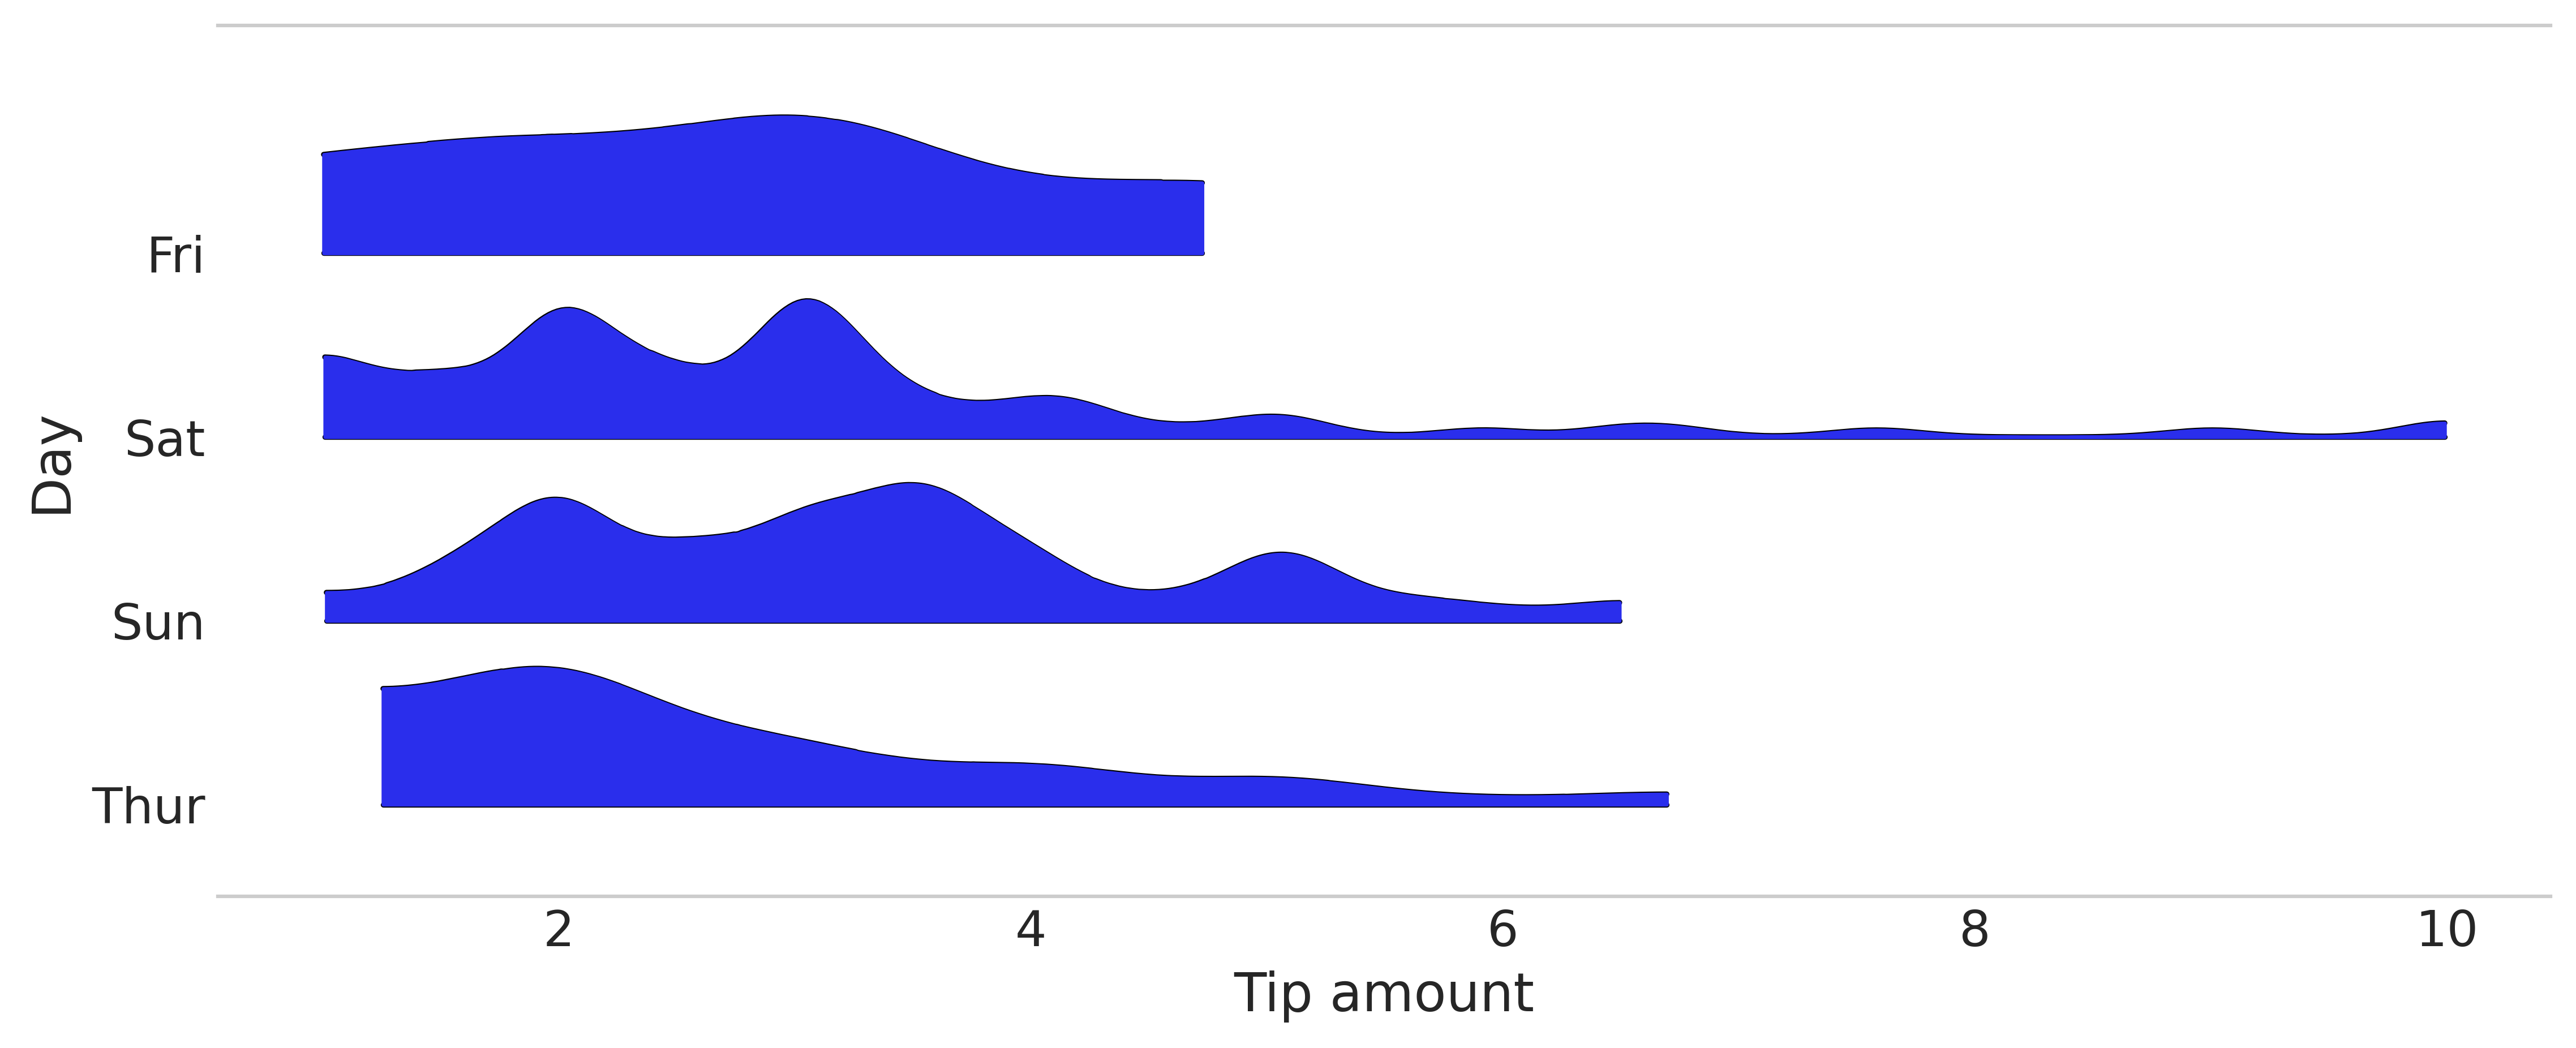

In [19]:
_, ax = plt.subplots(figsize=(10, 4))
az.plot_forest(tips.pivot(columns="day", values="tip").to_dict("list"),
               kind="ridgeplot",
               hdi_prob=1,
               ax=ax)
ax.set_xlabel("Tip amount")
ax.set_ylabel("Day")

In [20]:
categories = np.array(["Thur", "Fri", "Sat", "Sun"])

tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=categories).codes

In [21]:
pooled_coords = {"data": np.arange(len(tip))}


with pm.Model(coords=pooled_coords) as pooled_model:
    μ = pm.HalfNormal("μ", sigma=5)
    σ = pm.HalfNormal("σ", sigma=1)

    y = pm.Gamma("y", mu=μ, sigma=σ, observed=tip, dims="data")


unpooled_coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=unpooled_coords) as unpooled_model:
    μ = pm.HalfNormal("μ", sigma=5, dims="days")
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

models = {"pooled": pooled_model, "unpooled": unpooled_model}

In [22]:
idatas = {}
for model_name, model in models.items():
    with model:
        idata = pm.sample(2000, tune=1000)
        pm.sample_posterior_predictive(idata, extend_inferencedata=True)
        idatas[model_name] = idata



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
Sampling: [y]


Output()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.
Sampling: [y]


Output()

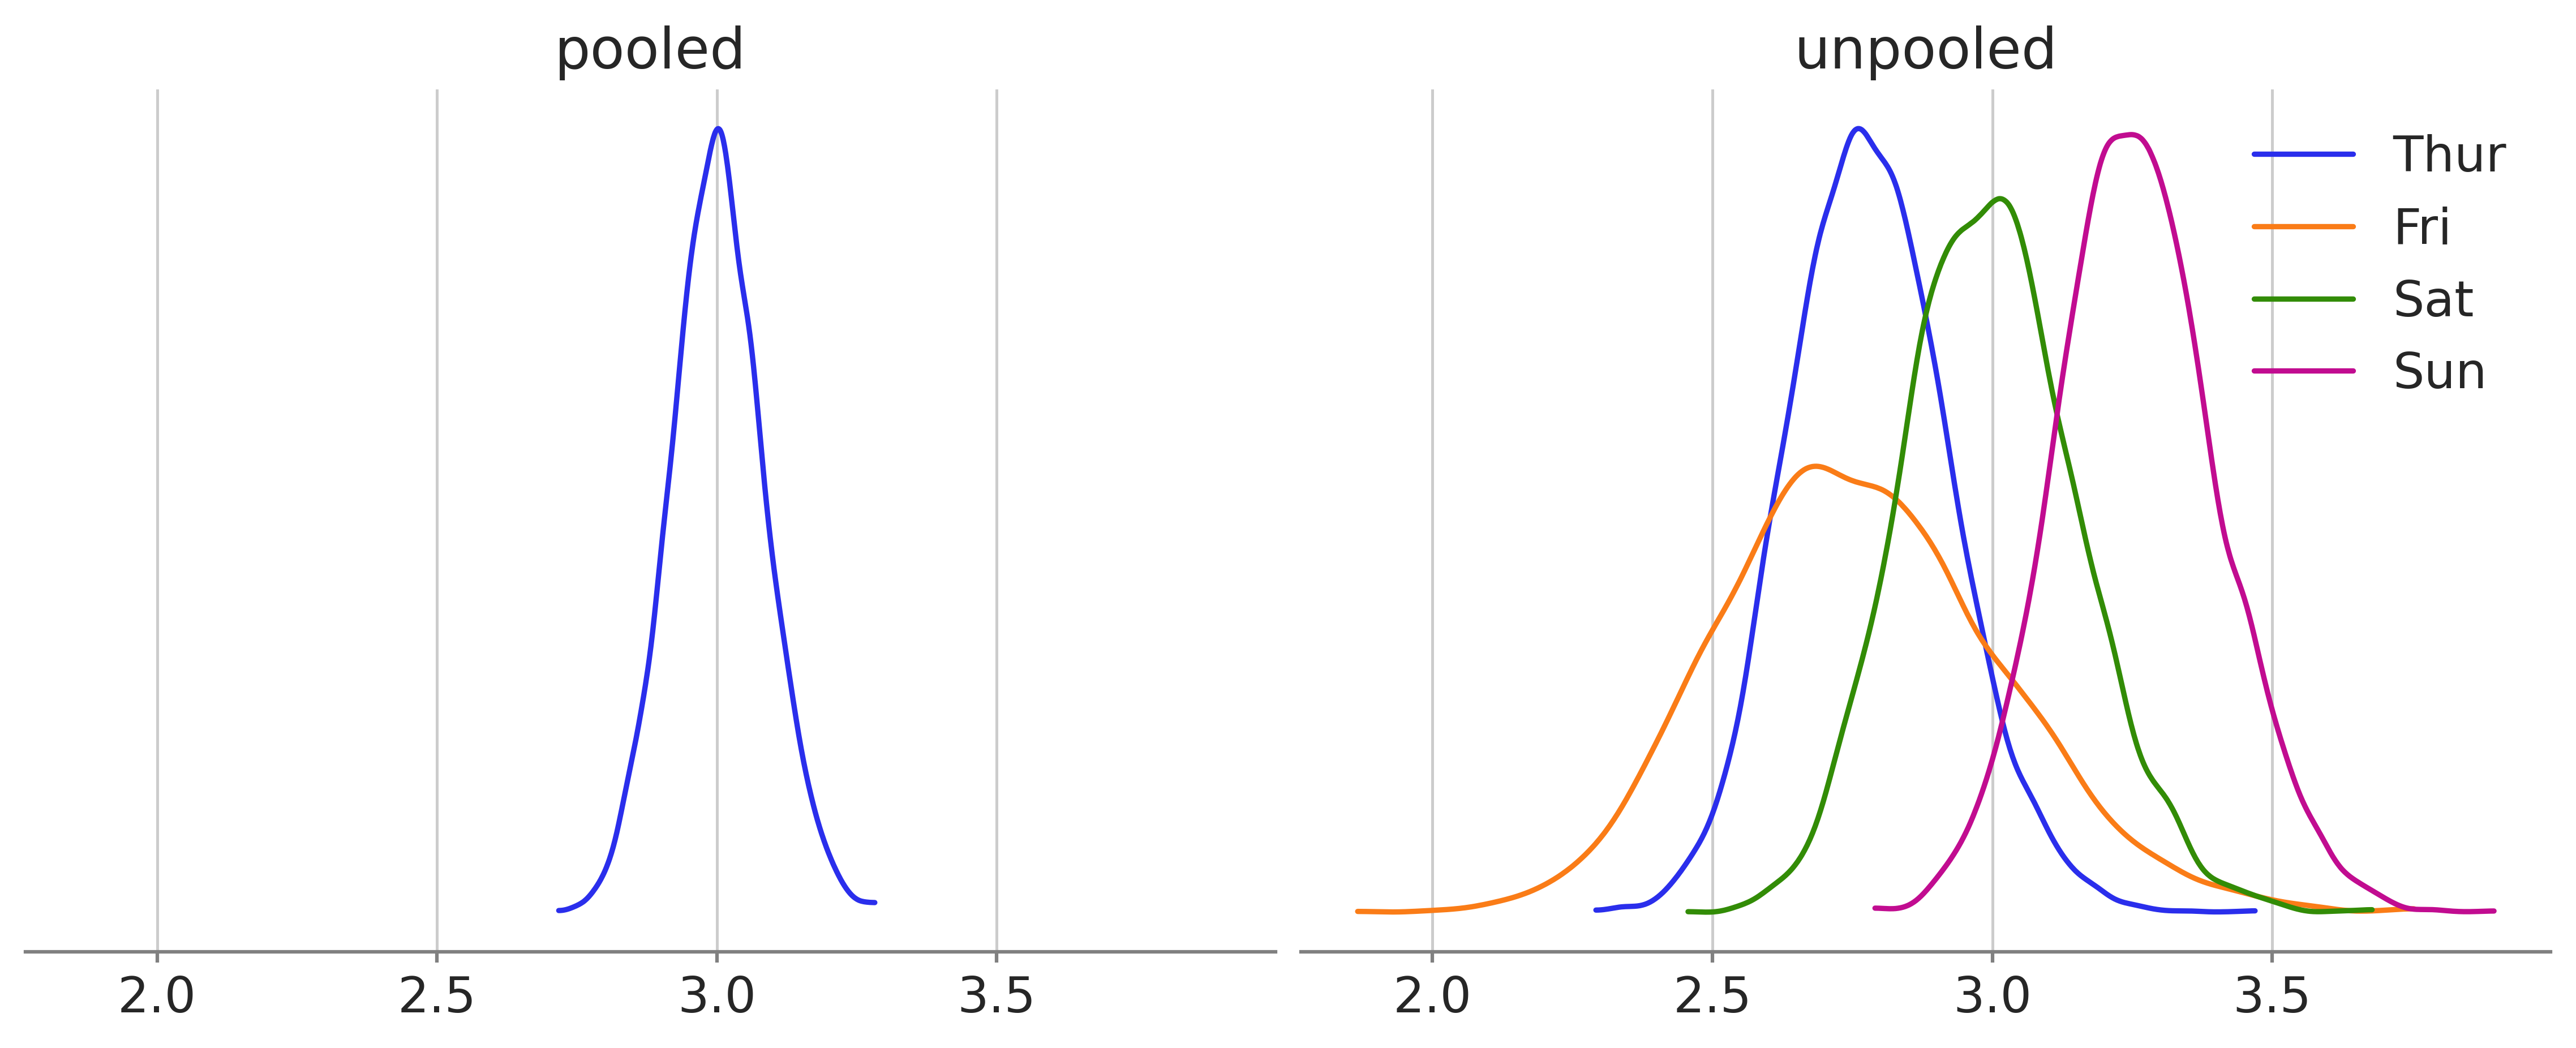

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
for i, (model_name, idata) in enumerate(idatas.items()):
    if model_name == "pooled":
        pm.plot_posterior(idata, var_names=["μ", "σ"], ax=ax[i], hdi_prob='hide', point_estimate=None)
    else:
        for j,day in enumerate(categories):
            pm.plot_posterior(idata, var_names=["μ", "σ"], hdi_prob='hide', point_estimate=None,
                              color=f"C{j}", coords={"days": day}, label=f'{day}', 
                              ax=ax[i])
        ax[i].legend()
    ax[i].set_title(model_name)
plt.show()


<Axes: title={'center': 'μ'}>

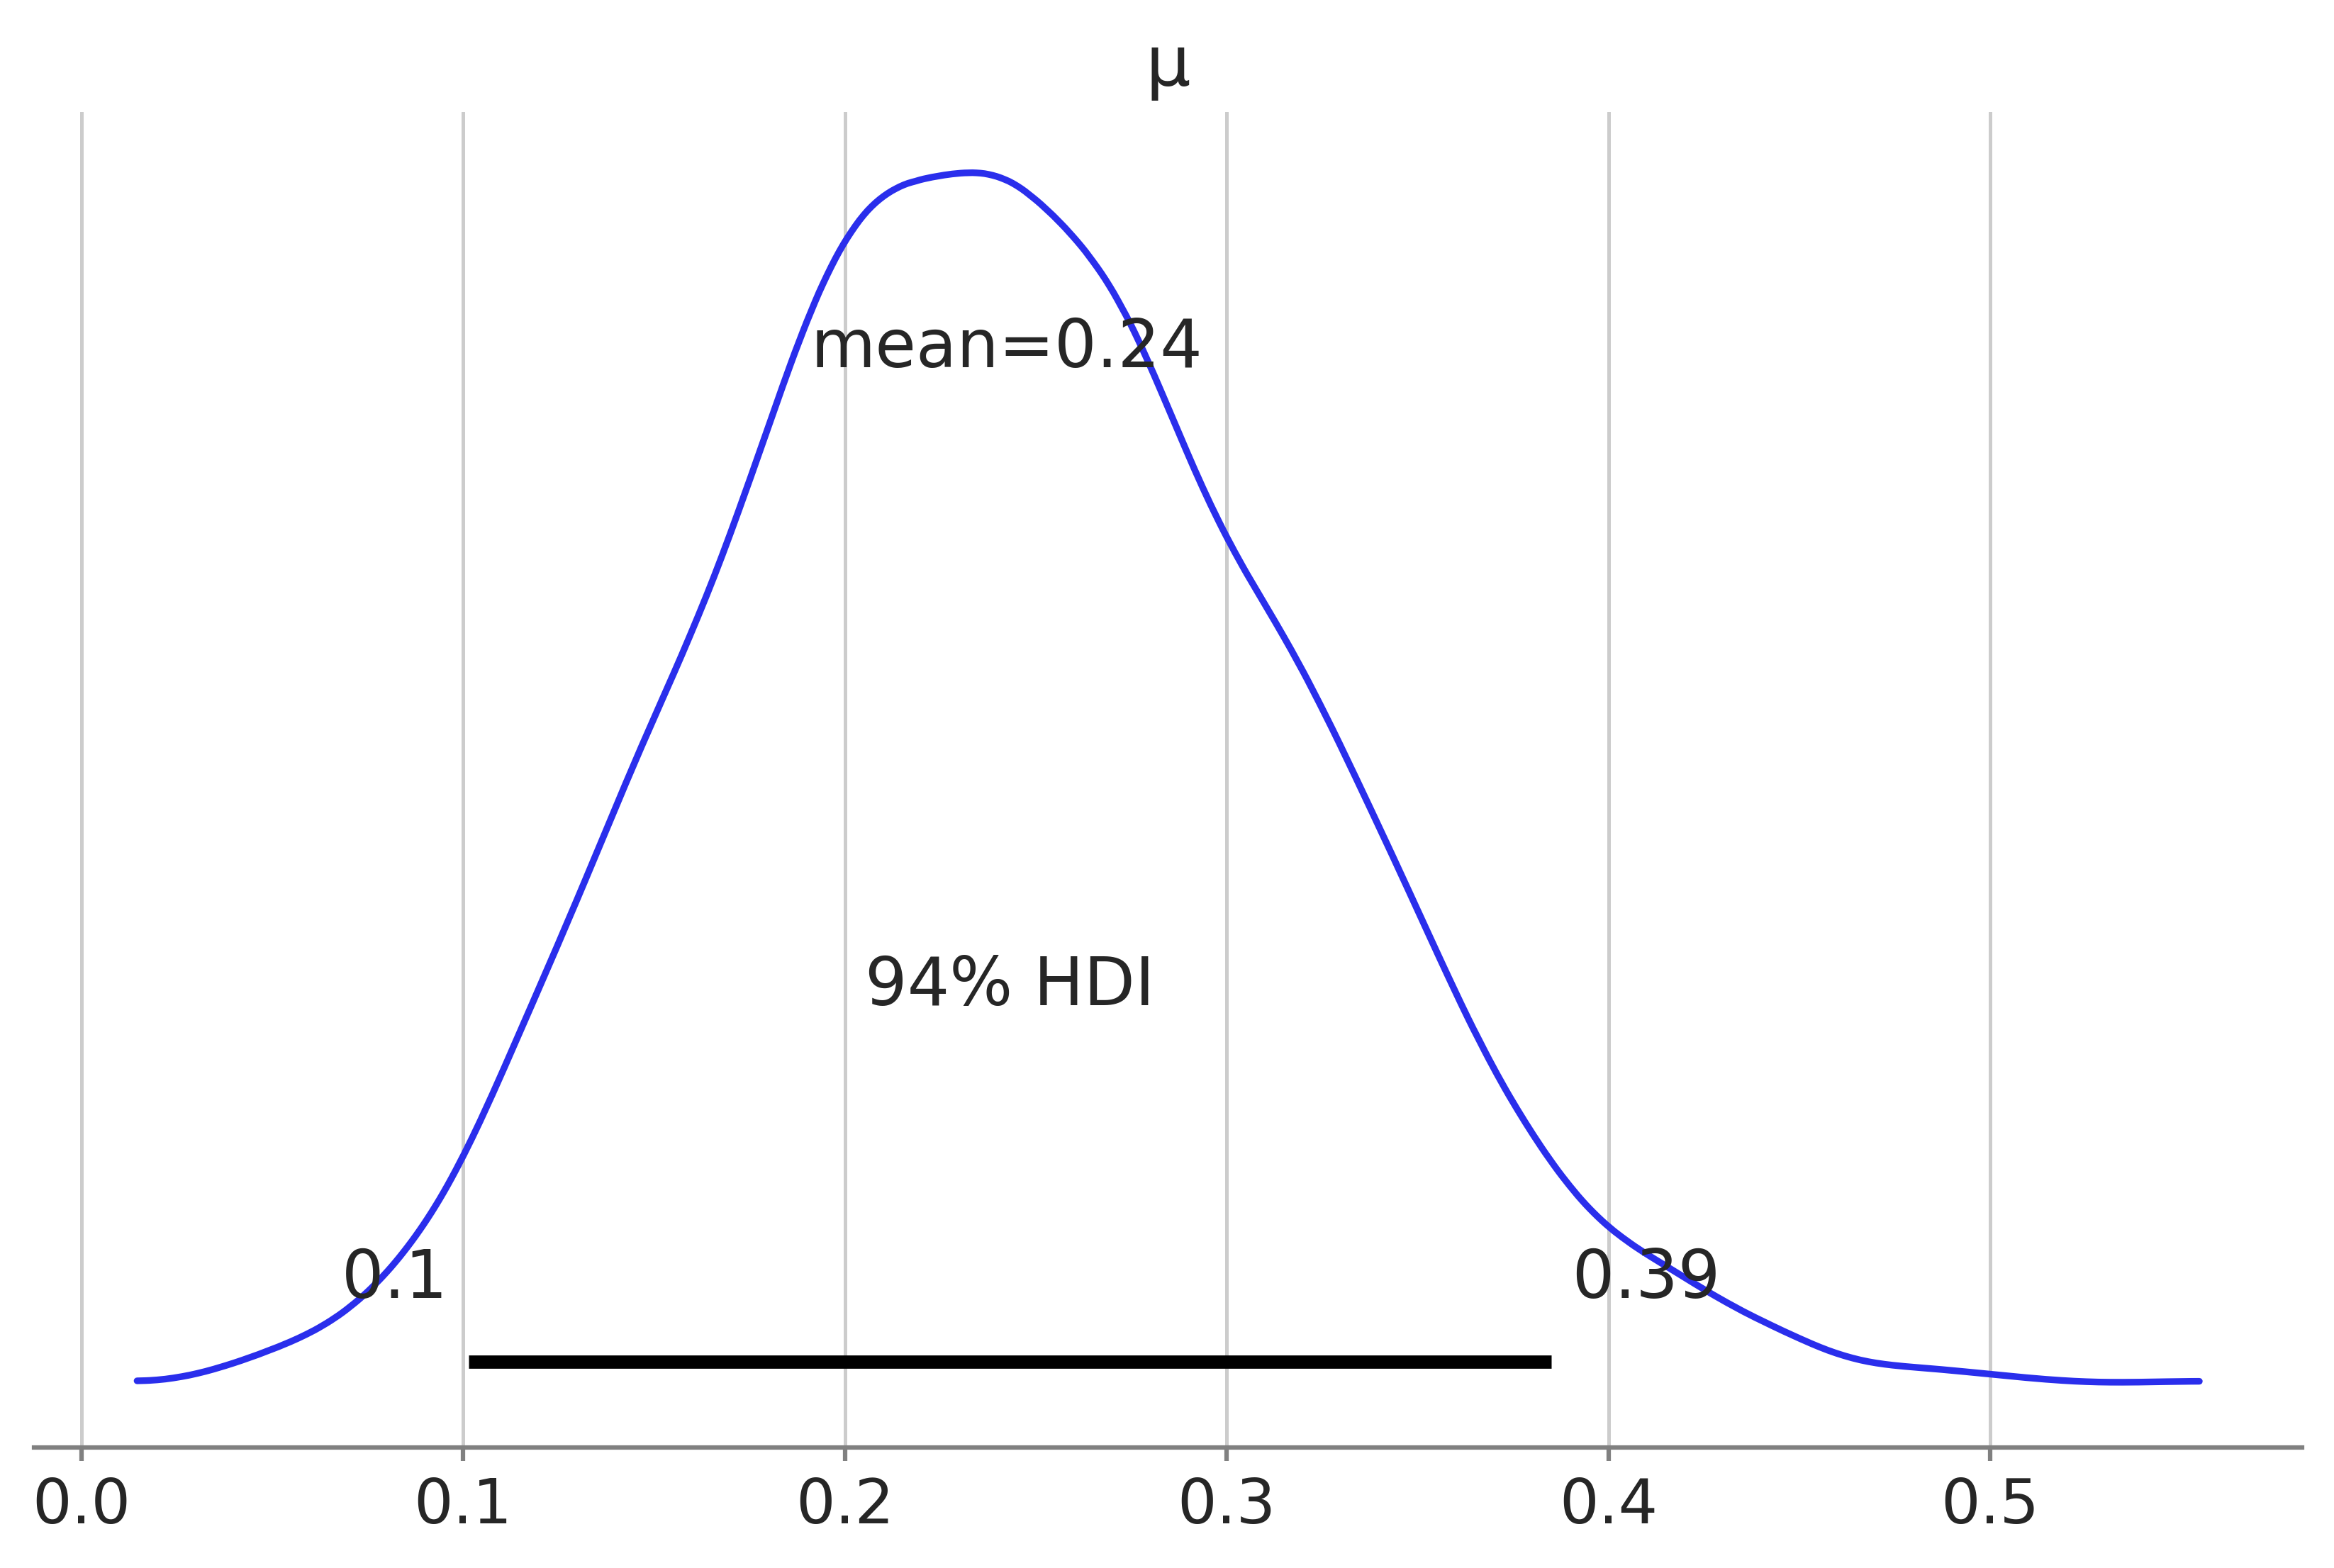

In [74]:
mu = idatas["unpooled"].posterior["μ"]
az.plot_posterior(mu.std(dim="days"))

mu_mu: mean: 2.424196969171701, std: 0.7914768209501252


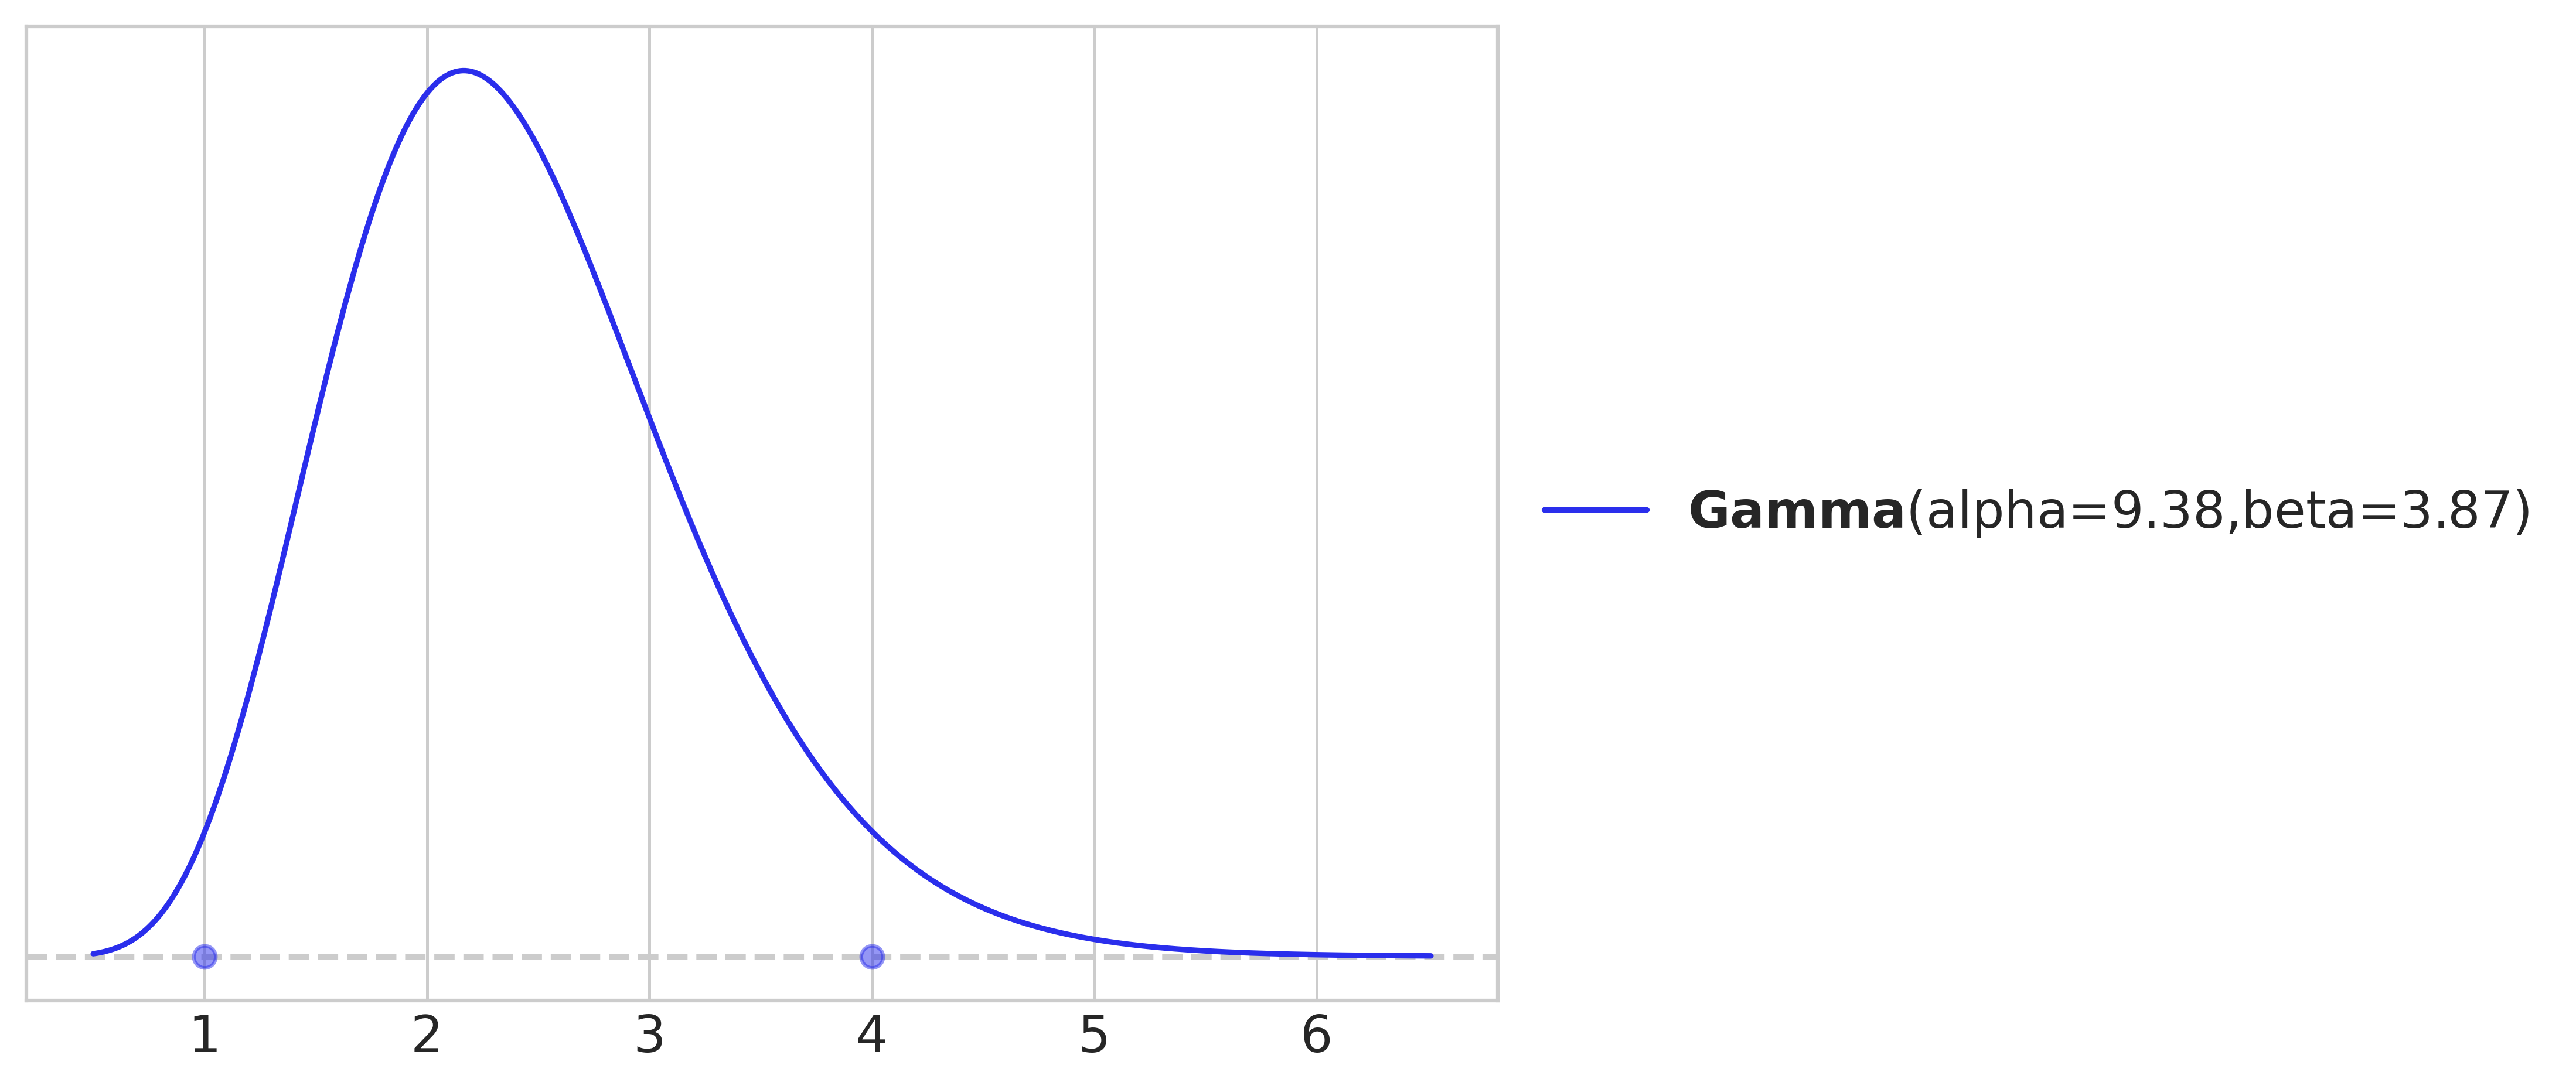

In [56]:
gma = pz.Gamma()
pz.maxent(gma, lower=1, upper=4, mass=0.95)
print(f"mu_mu: mean: {gma.mean()}, std: {gma.std()}")

mu_mu: mean: 0.22464897165950165, std: 0.14204033992030463


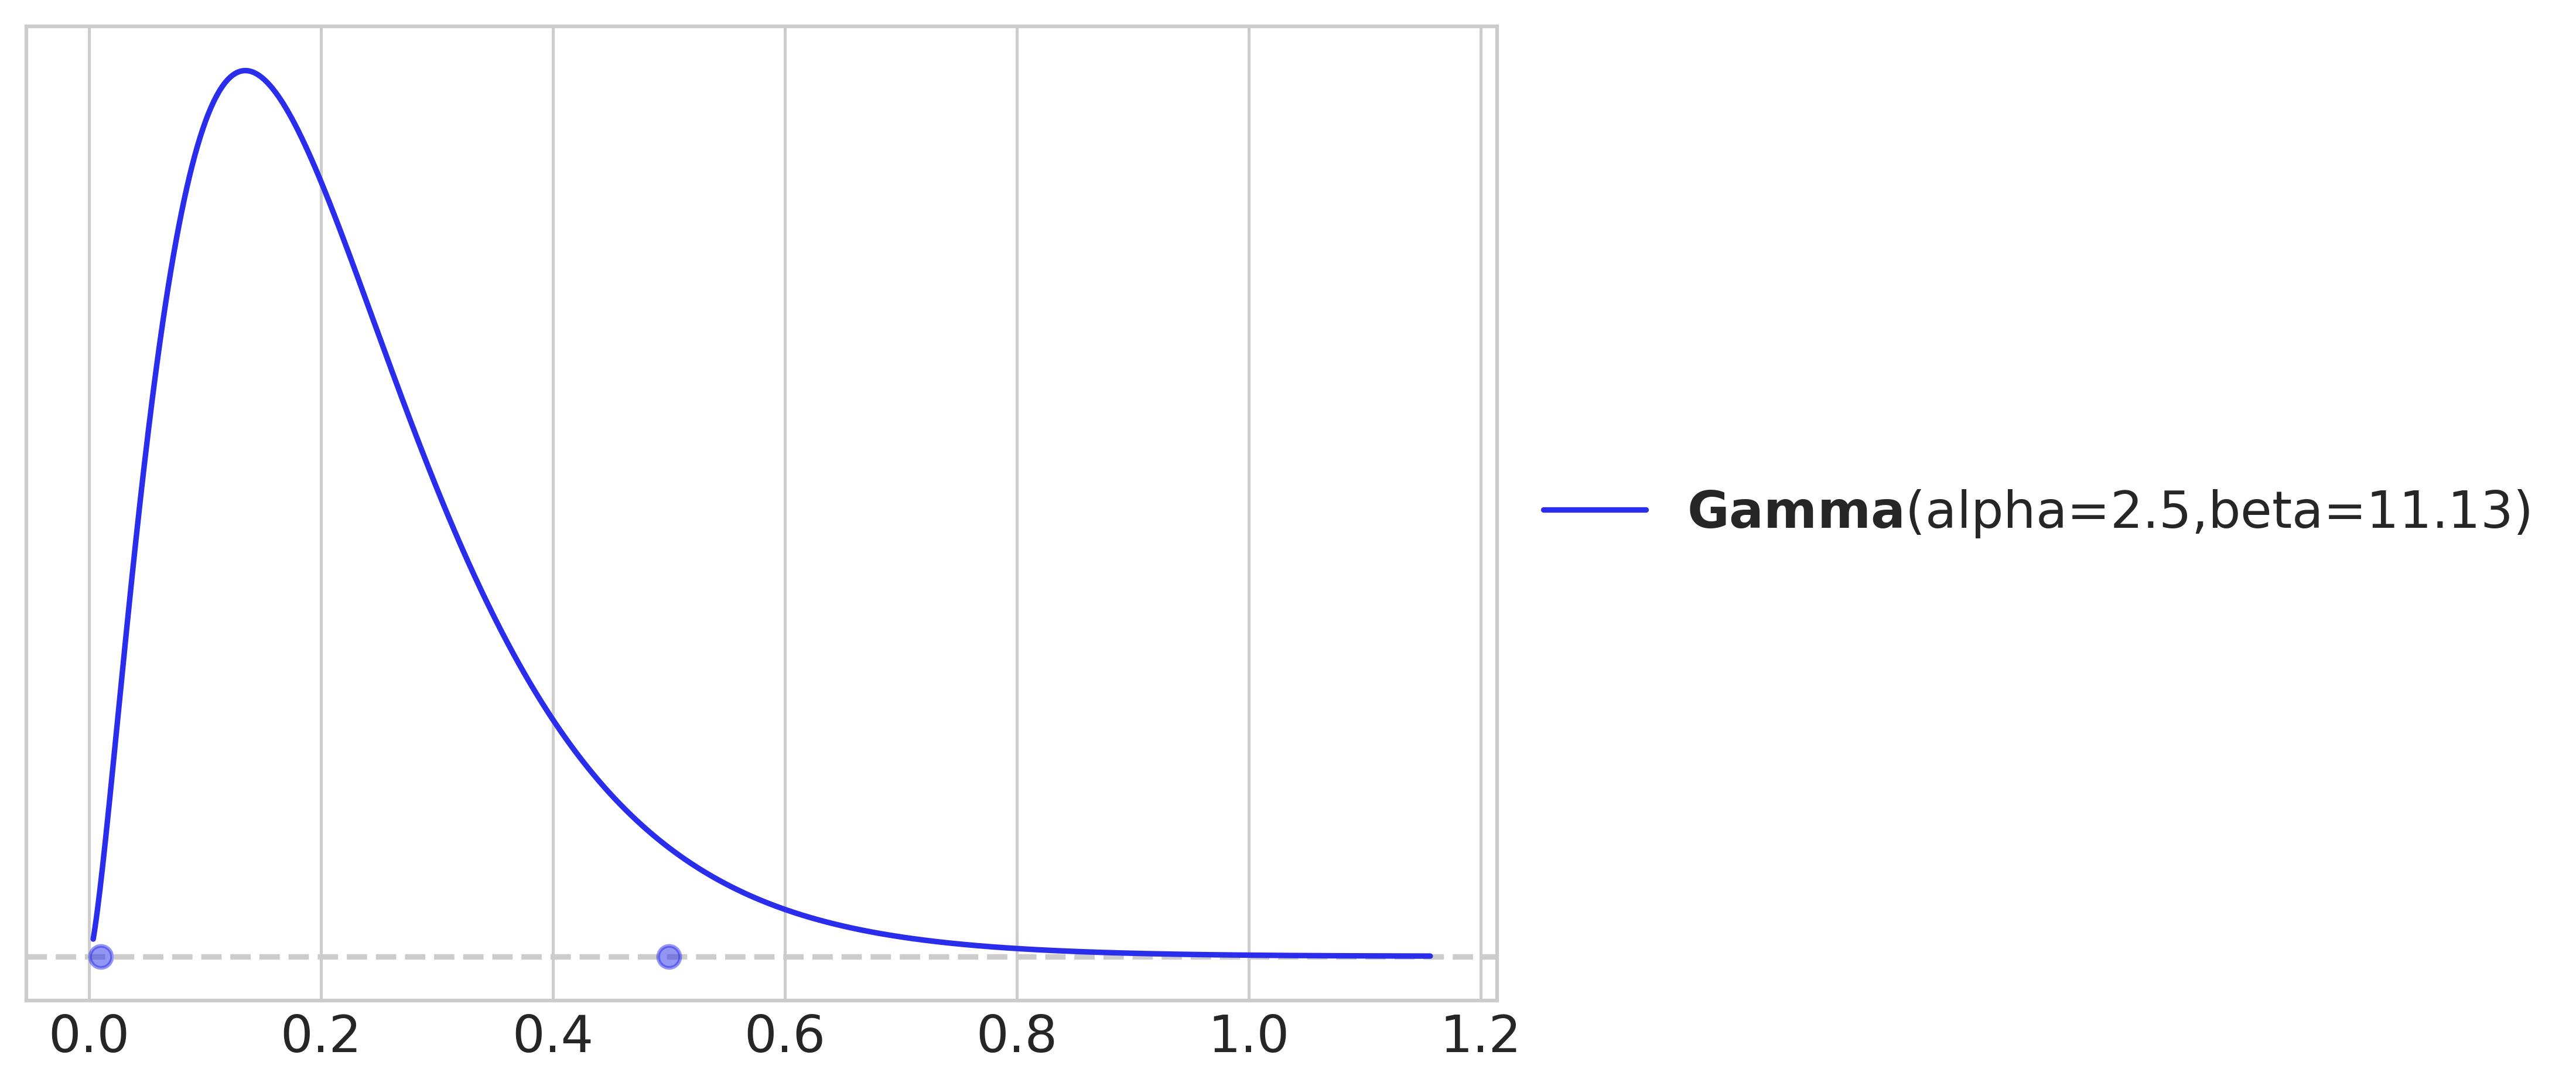

In [81]:
gma = pz.Gamma()
pz.maxent(gma, lower=0.01, upper=0.5, mass=0.95)
print(f"mu_mu: mean: {gma.mean()}, std: {gma.std()}")

In [82]:
partial_pooling_coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=partial_pooling_coords) as partial_pooling_model:
    μ_μ = pm.Gamma("μ_μ", mu=2.5, sigma=0.8)
    σ_μ = pm.Gamma("σ_μ", mu=0.22, sigma=0.14)
    
    μ = pm.Gamma("μ", mu=μ_μ, sigma=σ_μ, dims="days")
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

models = {"pooled": pooled_model, "unpooled": unpooled_model, "partial pooling": partial_pooling_model}

In [83]:
with partial_pooling_model:
    idata = pm.sample(2000, tune=2000, nuts={'target_accept': 0.99})
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)
idatas["partial pooling"] = idata

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_μ, σ_μ, μ, σ]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 36 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


Output()

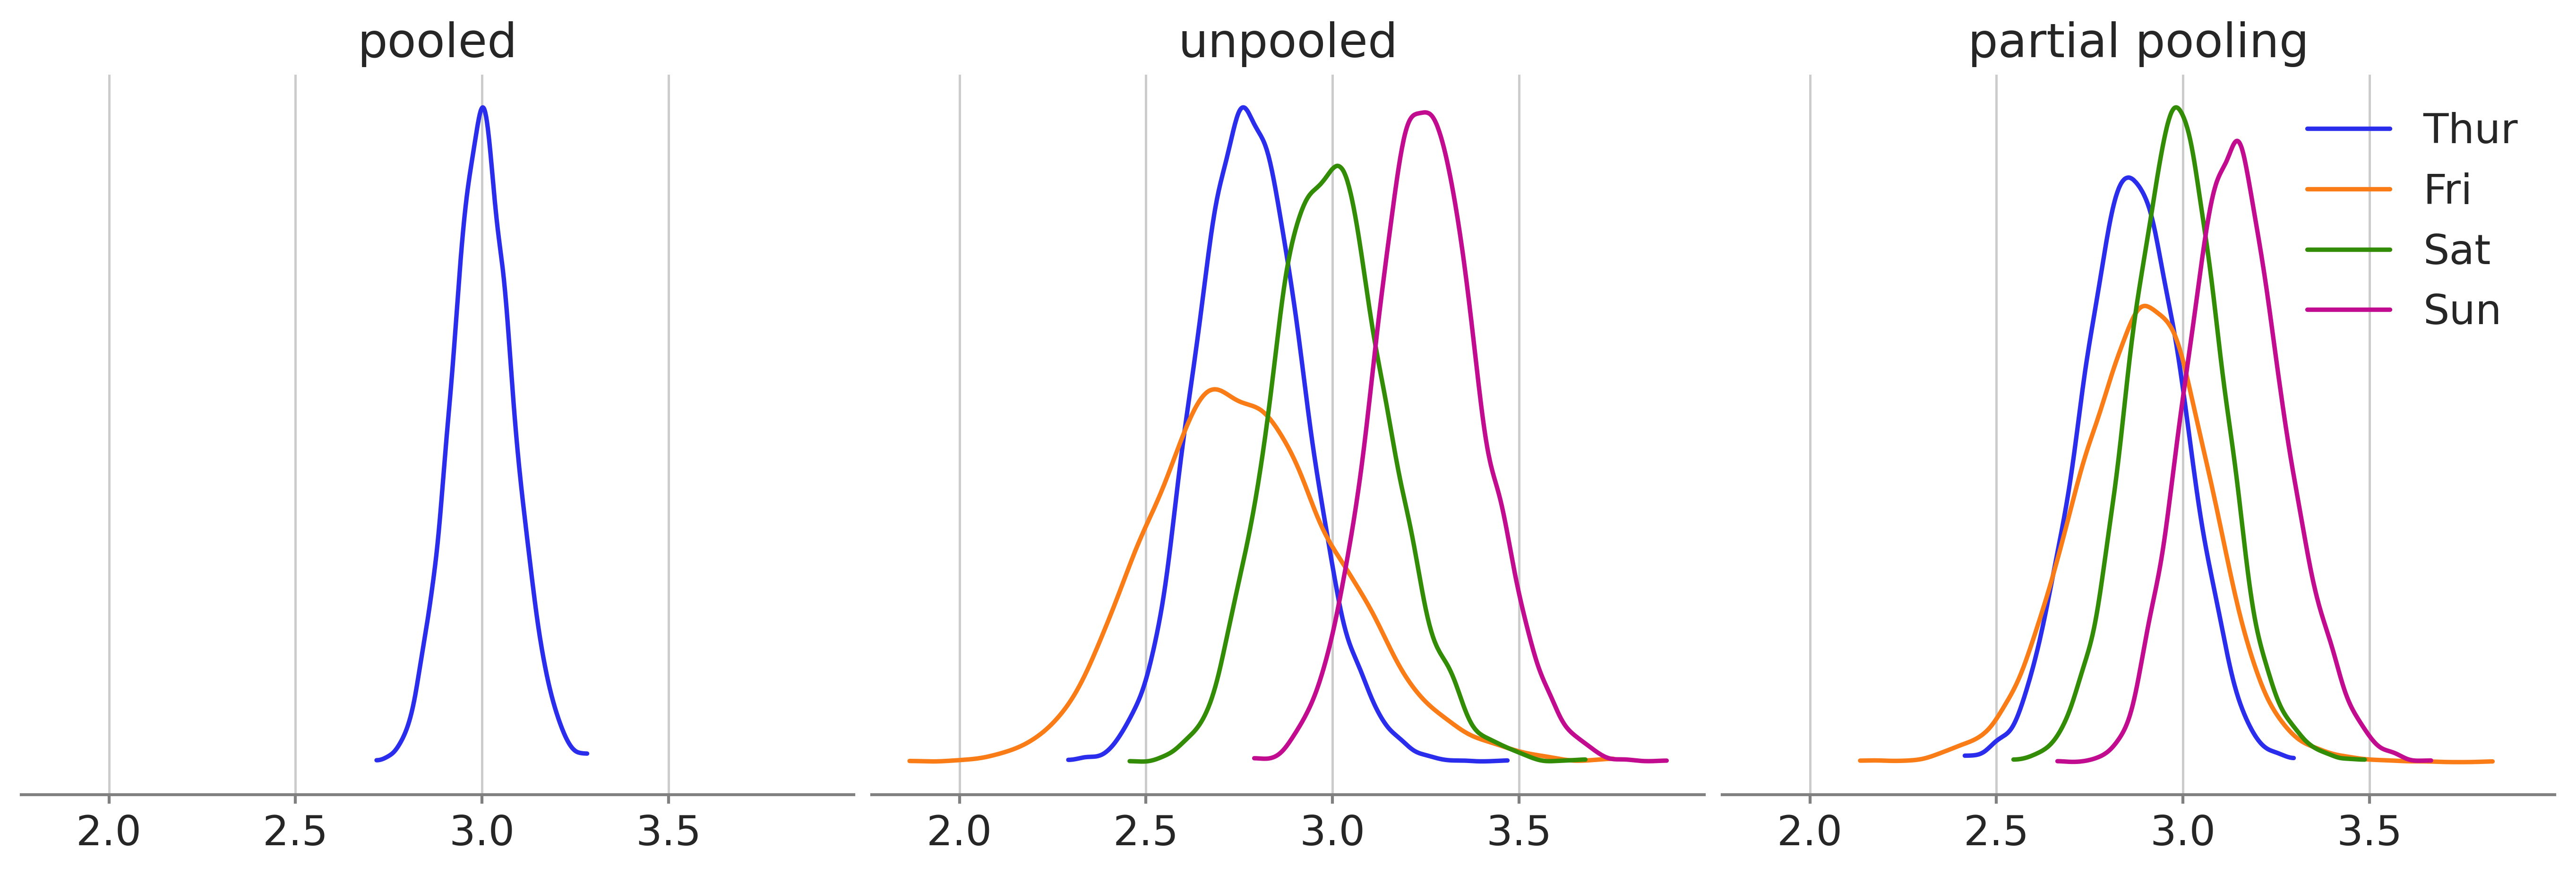

In [84]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
for i, (model_name, idata) in enumerate(idatas.items()):
    if model_name == "pooled":
        pm.plot_posterior(idata, var_names=["μ", "σ"], ax=ax[i], hdi_prob='hide', point_estimate=None)
    else:
        for j,day in enumerate(categories):
            pm.plot_posterior(idata, var_names=["μ", "σ"], hdi_prob='hide', point_estimate=None,
                              color=f"C{j}", coords={"days": day}, label=f'{day}', 
                              ax=ax[i])
    ax[i].set_title(model_name)
ax[1].get_legend().remove()
ax[2].legend()
plt.show()

array([<Axes: >], dtype=object)

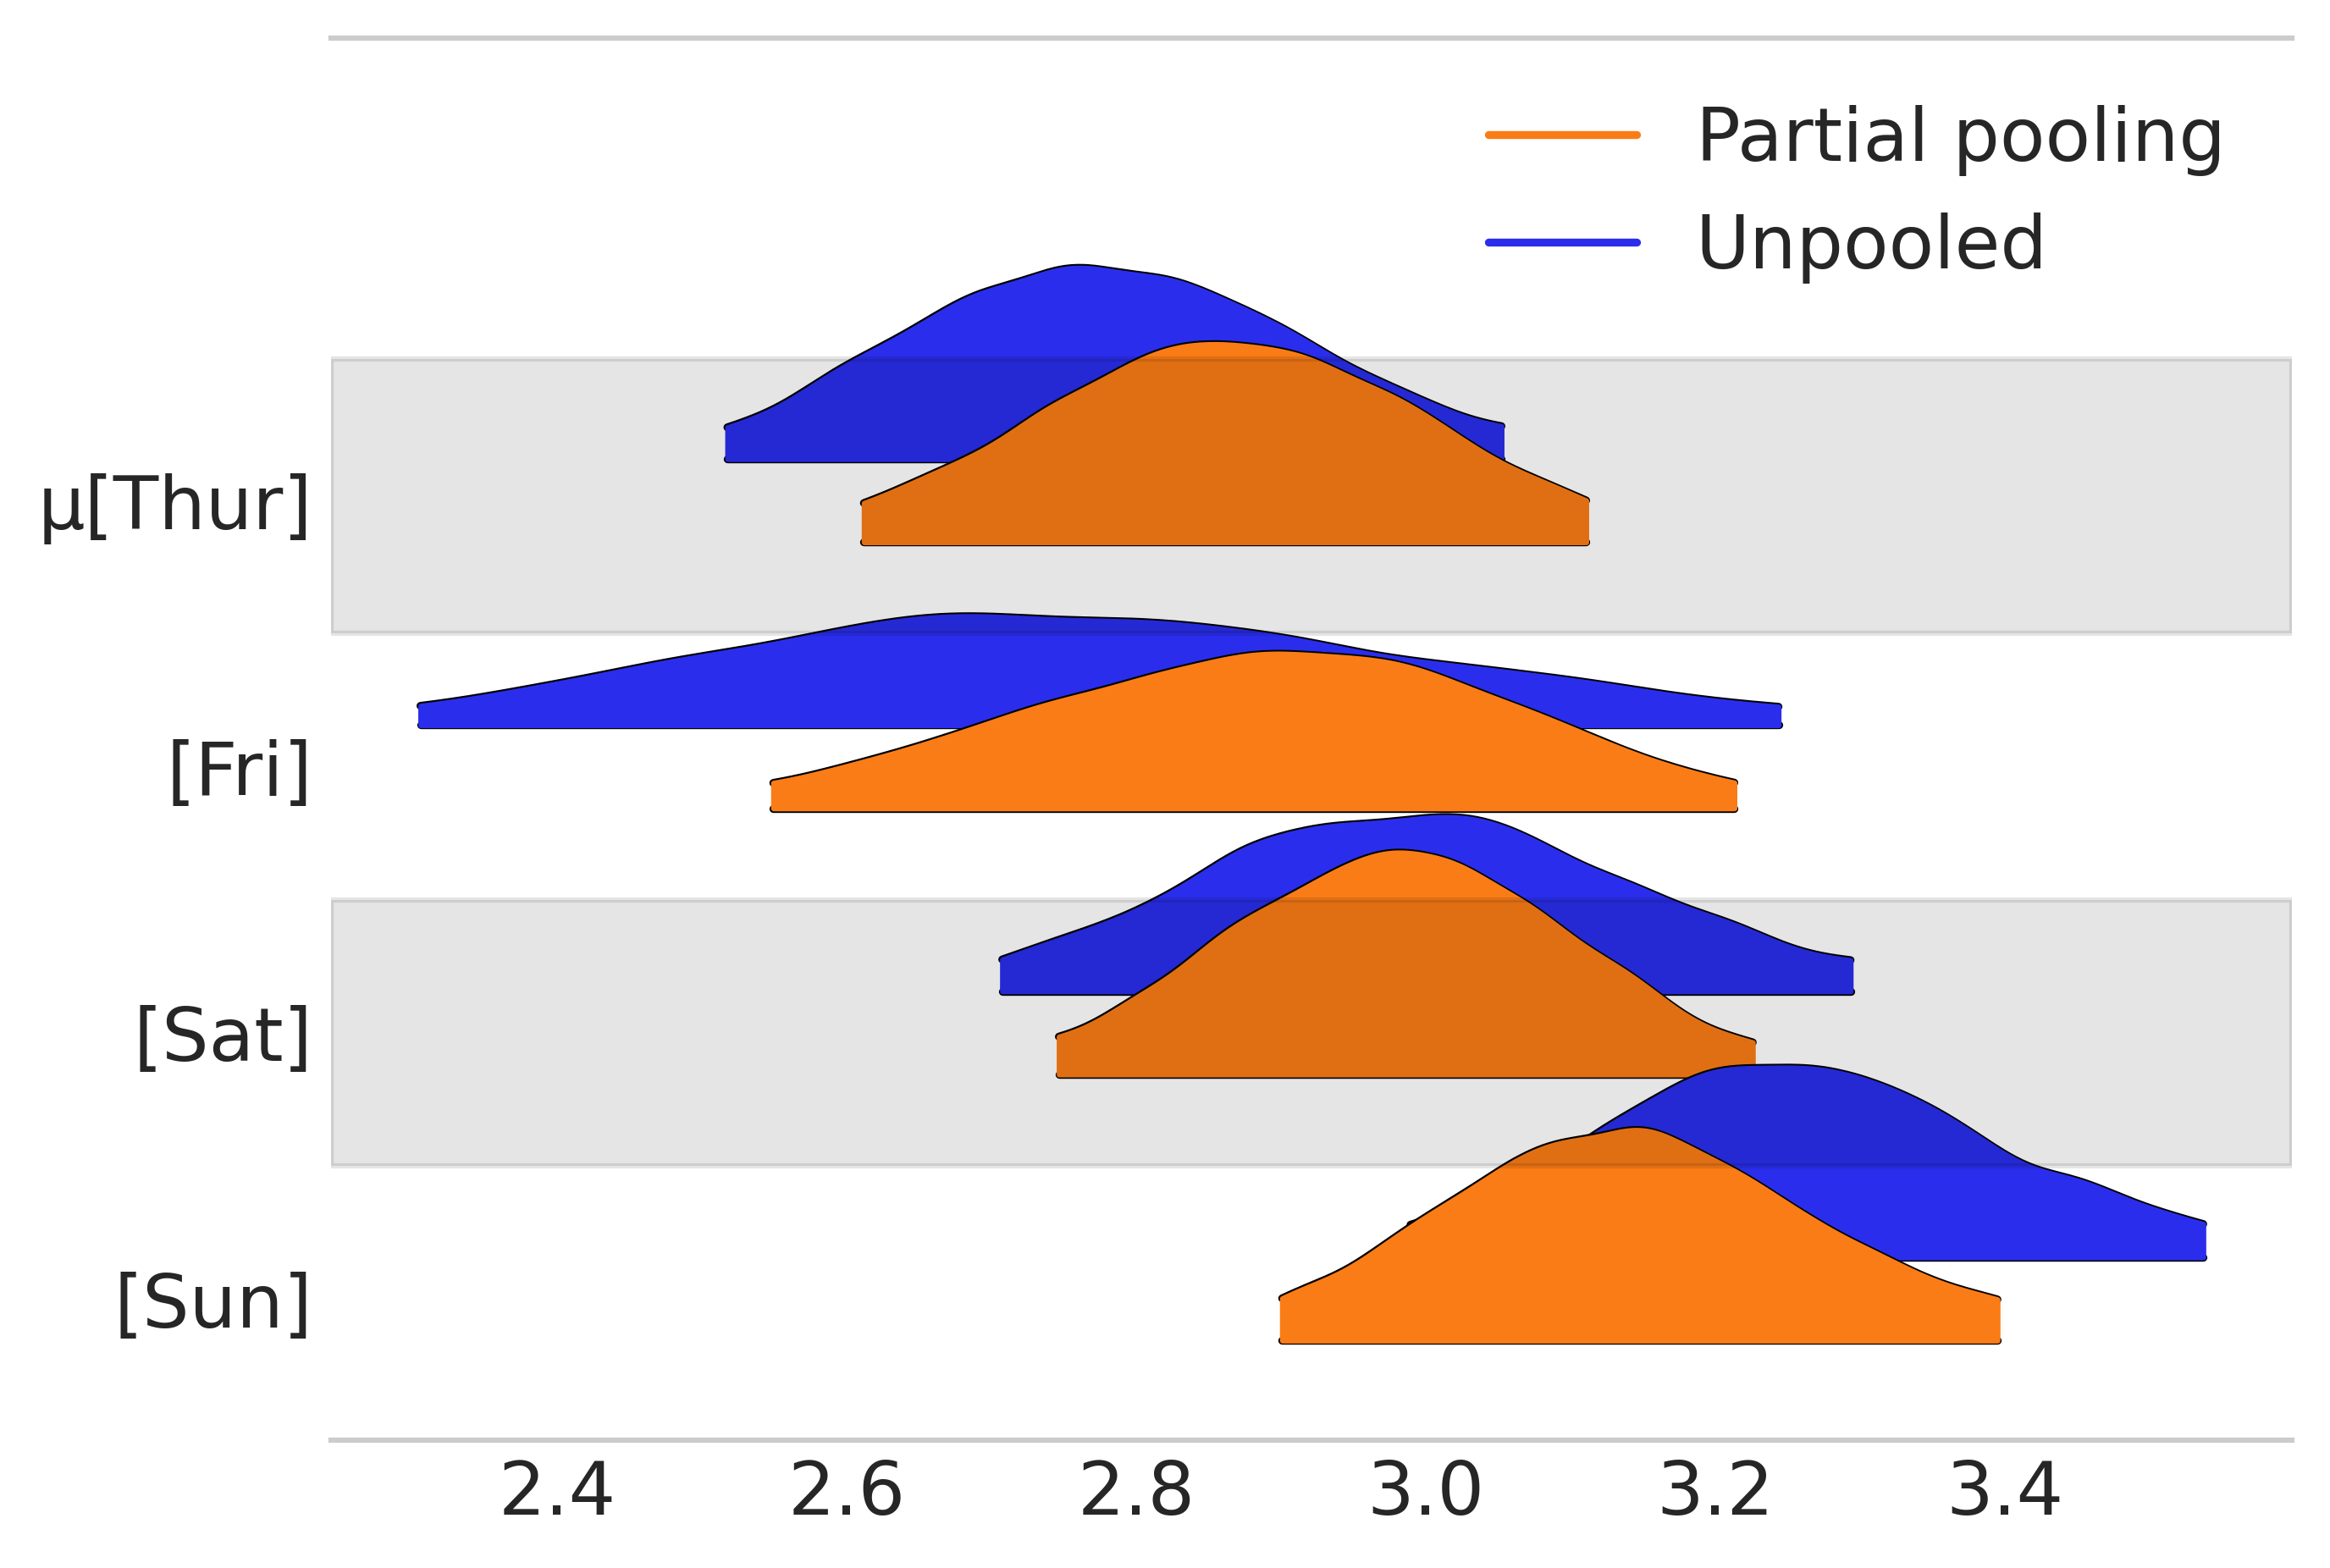

In [ ]:
az.plot_forest([idatas["unpooled"], idatas["partial pooling"]], 
               var_names="μ", model_names=["Unpooled", "Partial pooling"], 
               kind="ridgeplot",
               combined=True, figsize=(6, 4))